In [13]:
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt


def plot_pipeline_parallel_batches(batches, title="Pipeline Parallelism"):
    # batches[epoch][stage][micro_batch_index]
    num_steps = 0
    num_stages = 0
    for epoch in range(len(batches)):
        for stage in range(len(batches[epoch])):
            for mb_index in range(len(batches[epoch][stage])):
                mb = batches[epoch][stage][mb_index]
                num_steps = max(
                    num_steps,
                    max(
                        mb.forward_ts + mb.forward_cost,
                        mb.backward_ts + mb.backward_cost,
                    ),
                )
                num_stages = max(num_stages, mb.stage + 1)

    scale = 4
    fig, ax = plt.subplots(figsize=(scale * (num_steps / num_stages), scale))
    ax.set_title(title)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(num_steps))
    ax.set_yticks(
        np.arange(num_stages), labels=["worker-{}".format(i) for i in range(num_stages)]
    )
    ax.set_aspect(aspect=2)
    ax.invert_yaxis()

    # Minor ticks
    ax.set_xticks(np.arange(-0.5, num_steps, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, num_stages, 1), minor=True)

    # Gridlines based on minor ticks
    ax.grid(which="minor", color="black", linestyle="-", linewidth=1)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_axisbelow(True)

    rect_kwargs = {
        "edgecolor": "black",
        "linestyle": "-",
        "linewidth": 1,
    }
    text_kwargs = {
        "fontsize": "x-large",
        "ha": "center",
        "va": "center",
    }
    patches = []
    for epoch in range(len(batches)):
        for stage in range(len(batches[epoch])):
            for mb_index in range(len(batches[epoch][stage])):
                mb = batches[epoch][stage][mb_index]
                patches.append(
                    matplotlib.patches.Rectangle(
                        (mb.forward_ts - 0.5, mb.stage - 0.5),
                        mb.forward_cost,
                        1,
                        facecolor="royalblue",
                        **rect_kwargs,
                    )
                )
                patches.append(
                    matplotlib.patches.Rectangle(
                        (mb.backward_ts - 0.5, mb.stage - 0.5),
                        mb.backward_cost,
                        1,
                        facecolor="lightgreen",
                        **rect_kwargs,
                    )
                )
                ax.text(
                    mb.forward_ts + (mb.forward_cost - 1) / 2,
                    mb.stage,
                    mb.index,
                    color="white",
                    **text_kwargs,
                )
                ax.text(
                    mb.backward_ts + (mb.backward_cost - 1) / 2,
                    mb.stage,
                    mb.index,
                    color="blue",
                    **text_kwargs,
                )
    ax.add_collection(
        matplotlib.collections.PatchCollection(patches, match_original=True)
    )

    fig.tight_layout()
    plt.show()


def plot_pipeline_parallel(
    fn, num_stages=1, iteration=1, batch_size=64, micro_batch_size=8
):
    batches = fn(num_stages, iteration, batch_size, micro_batch_size)
    title = f"Pipeline Parallelism ({fn.__name__}) - {num_stages} stages, {iteration} iterations, {batch_size} batch size, {micro_batch_size} micro batch size"
    plot_pipeline_parallel_batches(batches, title)

In [14]:
# we asumpt that backward requires twice FLOPs as forward
forward_cost, backward_cost = 1, 2


class MicroBatch:
    def __init__(
        self,
        epoch=0,
        stage=0,
        micro_batch_index=0,
        num_micro_batches=-1,
        forward_cost=1,
        backward_cost=2,
    ):
        self.epoch = epoch
        self.stage = stage
        self.micro_batch_index = micro_batch_index
        self.num_micro_batches = num_micro_batches
        self.forward_ts = -1
        self.backward_ts = -1

        self.forward_cost = forward_cost
        self.backward_cost = backward_cost

    @property
    def index(self):
        return self.num_micro_batches * self.epoch + self.micro_batch_index + 1

    def __str__(self):
        return f"{self.epoch}_{self.batch_index}_{self.micro_batch_index}"


def make_batches(num_stages, iteration=1, batch_size=64, micro_batch_size=8):
    # batches[epoch][stage][micro_batch_index]
    num_micro_batches = batch_size // micro_batch_size
    batches = [
        [
            [
                MicroBatch(epoch, stage, mb_index, num_micro_batches)
                for mb_index in range(batch_size // micro_batch_size)
            ]
            for stage in range(num_stages)
        ]
        for epoch in range(iteration)
    ]
    return batches


In [15]:
# GPipe: F-then-B

def pipeline_parallel_fthenb(
    num_stages, iteration=1, batch_size=64, micro_batch_size=8
):
    batches = make_batches(num_stages, iteration, batch_size, micro_batch_size)
    num_micro_batches = batch_size // micro_batch_size

    timestamp = 0
    for epoch in range(iteration):
        # forward
        batches[epoch][0][0].forward_ts = timestamp
        for mb_index in range(1, num_micro_batches):
            batches[epoch][0][mb_index].forward_ts = (
                batches[epoch][0][mb_index - 1].forward_ts + forward_cost
            )
        for stage in range(1, num_stages):
            for mb_index in range(0, num_micro_batches):
                batches[epoch][stage][mb_index].forward_ts = (
                    batches[epoch][stage - 1][mb_index].forward_ts + forward_cost
                )

        # backward
        batches[epoch][num_stages - 1][0].backward_ts = (
            batches[epoch][num_stages - 1][num_micro_batches - 1].forward_ts
            + forward_cost
        )
        for mb_index in range(1, num_micro_batches):
            batches[epoch][num_stages - 1][mb_index].backward_ts = (
                batches[epoch][num_stages - 1][mb_index - 1].backward_ts + backward_cost
            )
        for stage in range(num_stages - 1 - 1, -1, -1):
            for mb_index in range(0, num_micro_batches):
                batches[epoch][stage][mb_index].backward_ts = (
                    batches[epoch][stage + 1][mb_index].backward_ts + backward_cost
                )

        timestamp = batches[epoch][0][num_micro_batches - 1].backward_ts + backward_cost
    return batches

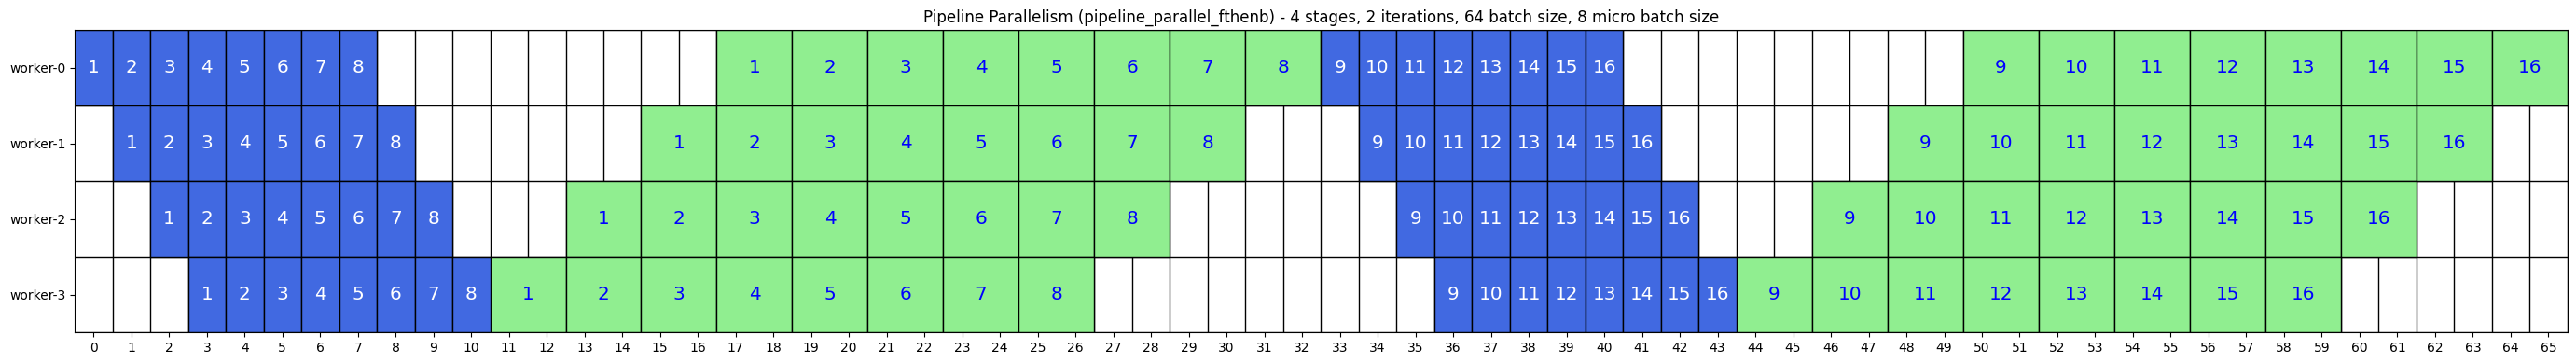

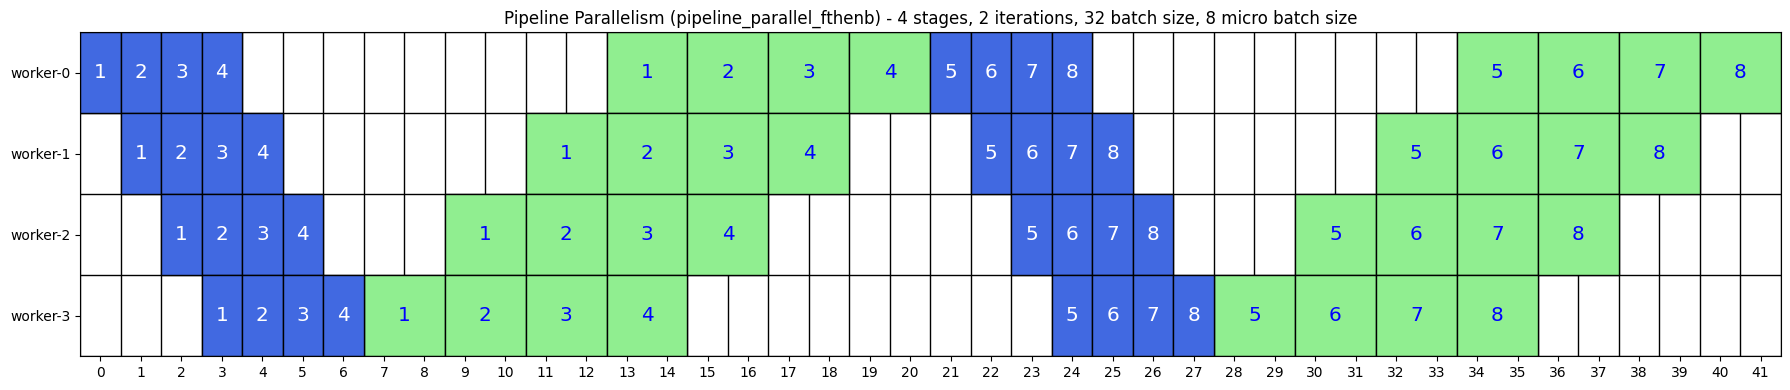

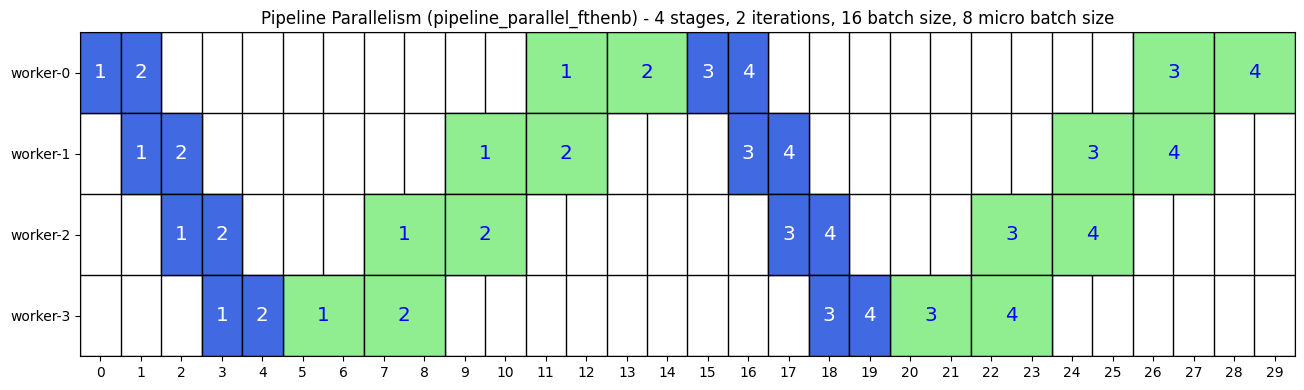

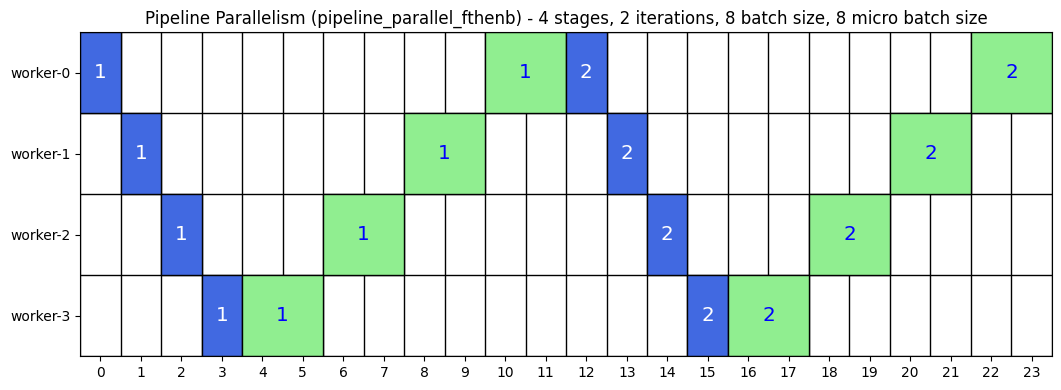

In [16]:
plot_pipeline_parallel(
    pipeline_parallel_fthenb,
    num_stages=4,
    iteration=2,
    batch_size=64,
    micro_batch_size=8,
)

plot_pipeline_parallel(
    pipeline_parallel_fthenb,
    num_stages=4,
    iteration=2,
    batch_size=32,
    micro_batch_size=8,
)

plot_pipeline_parallel(
    pipeline_parallel_fthenb,
    num_stages=4,
    iteration=2,
    batch_size=16,
    micro_batch_size=8,
)

plot_pipeline_parallel(
    pipeline_parallel_fthenb,
    num_stages=4,
    iteration=2,
    batch_size=8,
    micro_batch_size=8,
)

In [17]:
def pipeline_parallel_1f1b(
    num_stages,
    iteration=1,
    batch_size=64,
    micro_batch_size=8,
    no_flush=False,
    eager=False,
):
    """ The difference between the 1F1B and eager-1F1B is that the 1F1B runs
        (#stages - i + 1) warm up, while eager-1F1B runs (2 * (#stages - i) + 1)
        warm up.
    """
    if no_flush:
        num_micro_batches = batch_size * iteration // micro_batch_size
        batch_num_micro_batches = batch_size // micro_batch_size
        batches = make_batches(num_stages, 1, batch_size * iteration, micro_batch_size)
        iteration = 1
    else:
        num_micro_batches = batch_size // micro_batch_size
        batch_num_micro_batches = num_micro_batches
        batches = make_batches(num_stages, iteration, batch_size, micro_batch_size)

    if eager and no_flush:
        assert num_stages < batch_num_micro_batches, (
            "Eager 1F1B + Pipedream 2BW (no flushes) cannot work with cases where "
            + "the depth of pipeline parallelism is larger than or equal to the number "
            + "of micro-batches.",
        )
    if no_flush:
        assert num_stages <= batch_num_micro_batches, (
            "Pipedream 2BW (no flushes) cannot work with cases where "
            + "the depth of pipeline parallelism is larger than the number "
            + "of micro-batches.",
        )

    def compute_num_warmup_micro_batches(stage):
        if eager:
            return min(2 * (num_stages - stage - 1), batch_num_micro_batches)
        else:
            return min(num_stages - stage - 1, batch_num_micro_batches)

    timestamp = 0
    for epoch in range(iteration):
        # forward: run warmup micro-batches
        for stage in range(num_stages):
            num_warmup_micro_batches = compute_num_warmup_micro_batches(stage)
            if stage != num_stages - 1:
                batches[epoch][stage][0].forward_ts = timestamp + stage
                for mb_index in range(1, num_warmup_micro_batches):
                    batches[epoch][stage][mb_index].forward_ts = (
                        batches[epoch][stage][mb_index - 1].forward_ts + forward_cost
                    )

        # run 1F1B
        for stage in range(num_stages - 1, -1, -1):
            num_warmup_micro_batches = compute_num_warmup_micro_batches(stage)
            if stage == num_stages - 1:
                for mb_index in range(num_warmup_micro_batches, num_micro_batches):
                    if mb_index == 0:
                        batches[epoch][stage][mb_index].forward_ts = (
                            batches[epoch][stage - 1][0].forward_ts + forward_cost
                        )
                    else:
                        batches[epoch][stage][mb_index].forward_ts = (
                            batches[epoch][stage][mb_index - 1].backward_ts
                            + backward_cost
                        )
                    batches[epoch][stage][mb_index].backward_ts = (
                        batches[epoch][stage][mb_index].forward_ts + forward_cost
                    )
            else:
                backward_mb_index = 0
                for mb_index in range(num_warmup_micro_batches, num_micro_batches):
                    prev_backward_finished = (
                        batches[epoch][stage + 1][backward_mb_index].backward_ts
                        + backward_cost
                    )
                    if backward_mb_index == 0:
                        last_forward_finished = (
                            batches[epoch][stage][mb_index - 1].forward_ts
                            + forward_cost
                        )
                        batches[epoch][stage][mb_index].forward_ts = max(
                            last_forward_finished,
                            prev_backward_finished - forward_cost,
                        )
                    else:
                        last_backward_finished = (
                            batches[epoch][stage][backward_mb_index - 1].backward_ts
                            + backward_cost
                        )
                        batches[epoch][stage][mb_index].forward_ts = max(
                            last_backward_finished,
                            prev_backward_finished - forward_cost,
                        )
                    batches[epoch][stage][backward_mb_index].backward_ts = max(
                        batches[epoch][stage][mb_index].forward_ts + forward_cost,
                        prev_backward_finished,
                    )
                    backward_mb_index += 1

                # backward: run remaining micro-batches
                for mb_index in range(backward_mb_index, num_micro_batches):
                    batches[epoch][stage][mb_index].backward_ts = (
                        batches[epoch][stage + 1][mb_index].backward_ts + backward_cost
                    )

        timestamp = batches[epoch][0][num_micro_batches - 1].backward_ts + backward_cost
    return batches


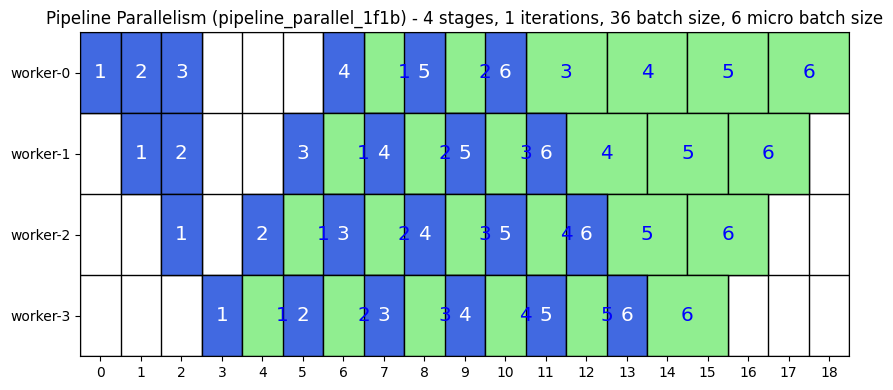

In [6]:
plot_pipeline_parallel(
    pipeline_parallel_1f1b, num_stages=4, iteration=1, batch_size=36, micro_batch_size=6
)

### plot_pipeline_parallel(
    pipeline_parallel_1f1b, num_stages=4, iteration=1, batch_size=64, micro_batch_size=8
)

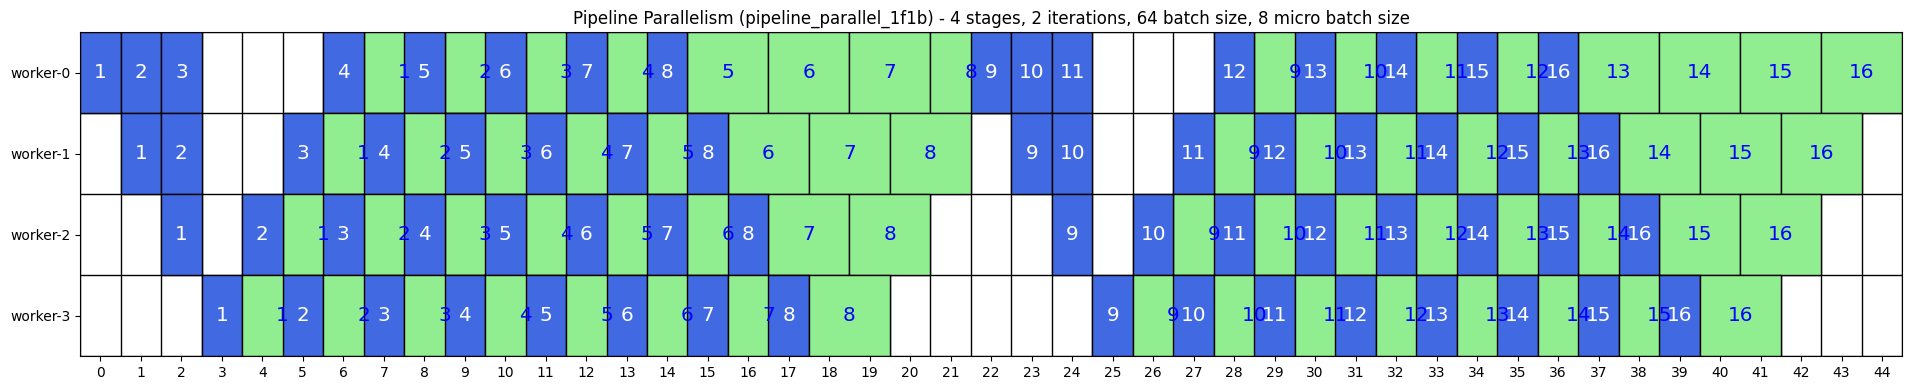

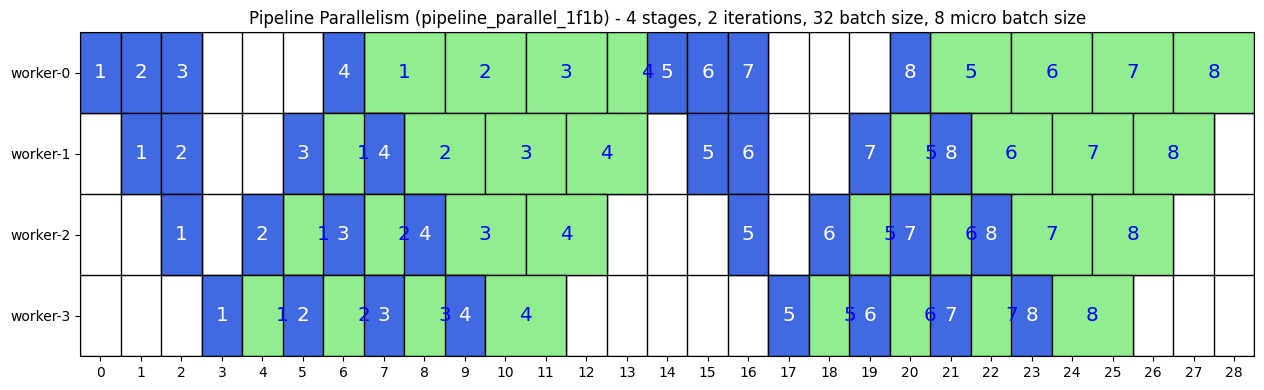

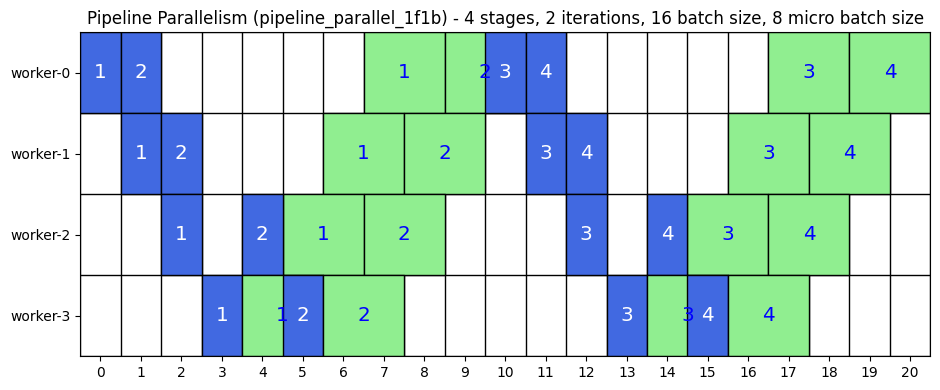

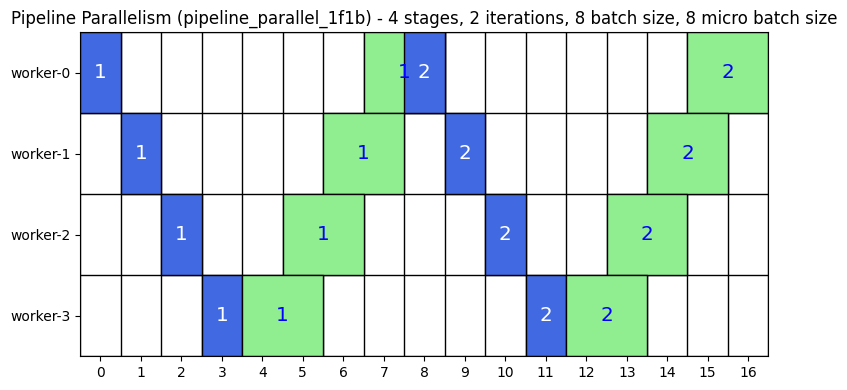

In [7]:
# PipeDream: 1F1B scheduling

plot_pipeline_parallel(
    pipeline_parallel_1f1b, num_stages=4, iteration=2, batch_size=64, micro_batch_size=8
)

plot_pipeline_parallel(
    pipeline_parallel_1f1b, num_stages=4, iteration=2, batch_size=32, micro_batch_size=8
)

plot_pipeline_parallel(
    pipeline_parallel_1f1b, num_stages=4, iteration=2, batch_size=16, micro_batch_size=8
)

plot_pipeline_parallel(
    pipeline_parallel_1f1b, num_stages=4, iteration=2, batch_size=8, micro_batch_size=8
)

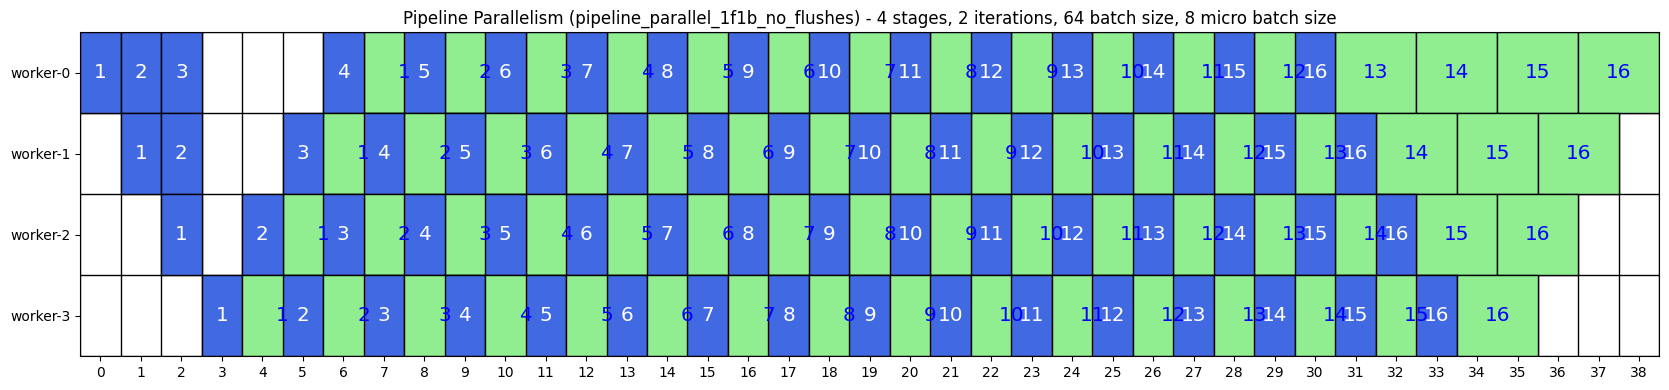

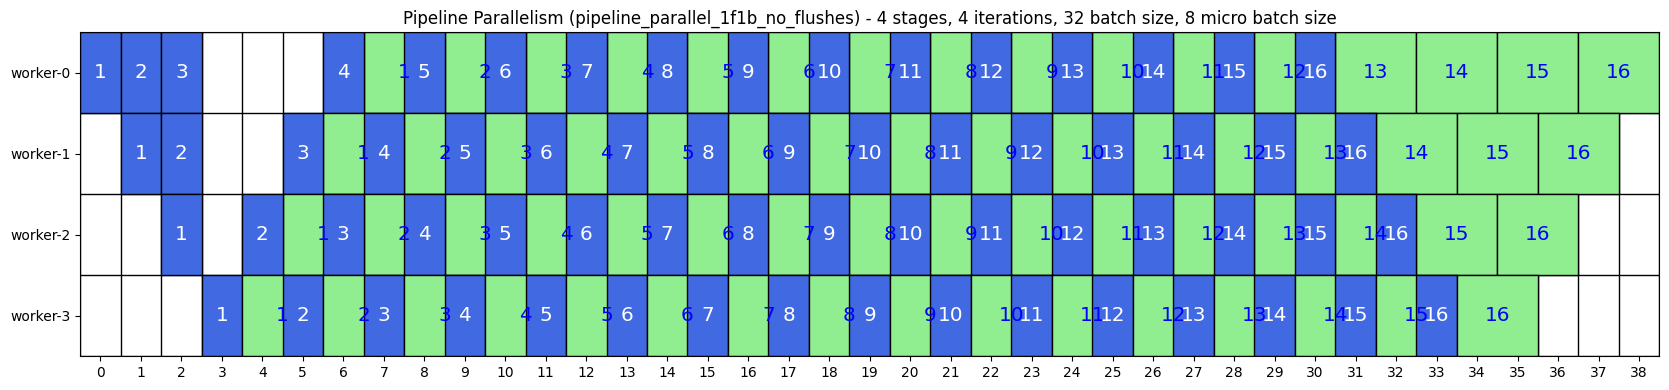

In [8]:
# Pipedream-2BW: 1F1B scheduling with 2BW (double-buffered weight updates)

def pipeline_parallel_1f1b_no_flushes(
    num_stages, iteration=1, batch_size=64, micro_batch_size=8
):
    # no flushes, equals to consecutive 1F1B
    return pipeline_parallel_1f1b(
        num_stages,
        iteration=iteration,
        batch_size=batch_size,
        micro_batch_size=micro_batch_size,
        no_flush=True,
    )


plot_pipeline_parallel(
    pipeline_parallel_1f1b_no_flushes,
    num_stages=4,
    iteration=2,
    batch_size=64,
    micro_batch_size=8,
)

plot_pipeline_parallel(
    pipeline_parallel_1f1b_no_flushes,
    num_stages=4,
    iteration=4,
    batch_size=32,
    micro_batch_size=8,
)

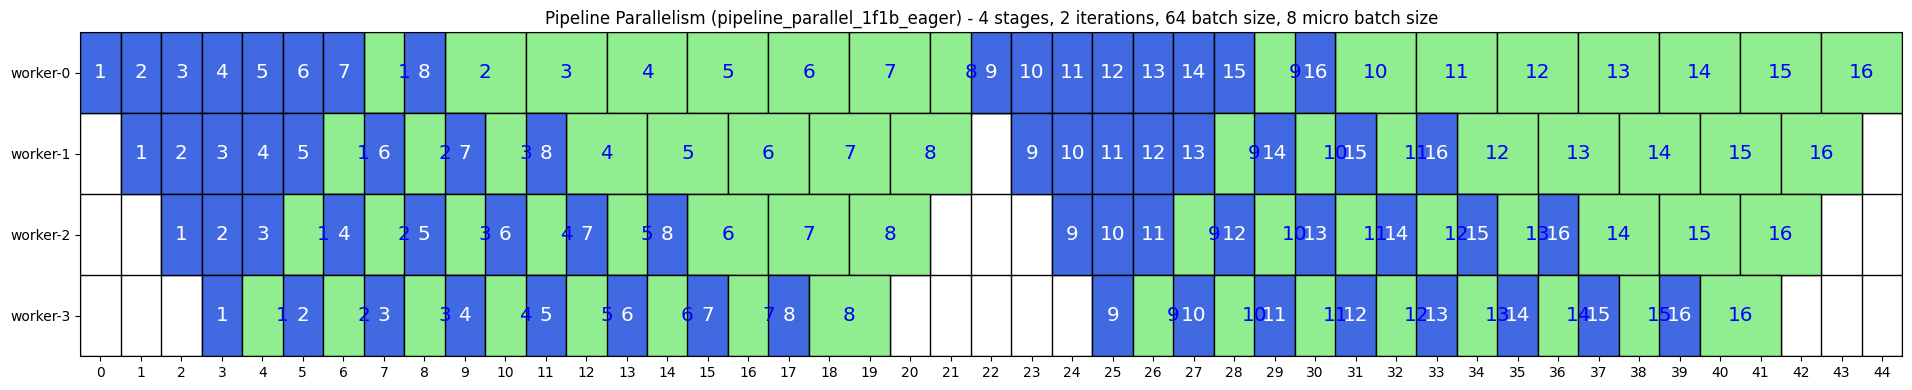

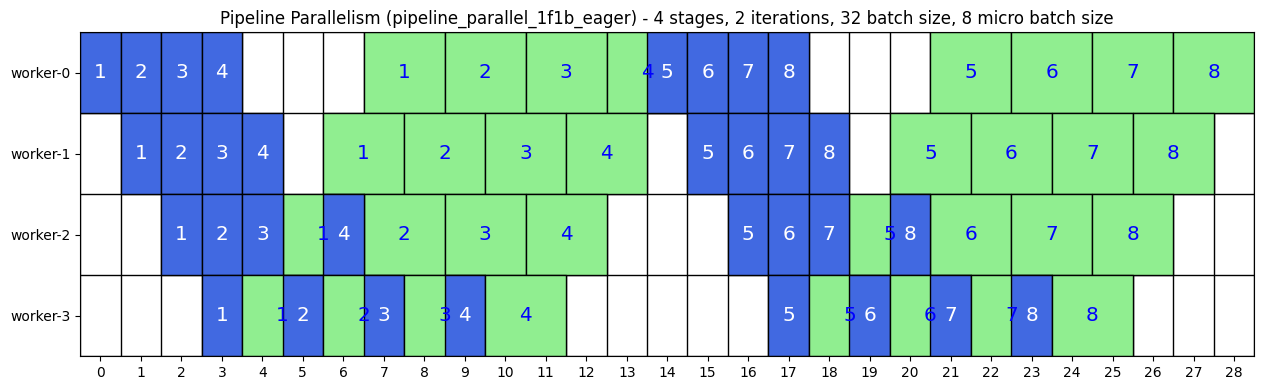

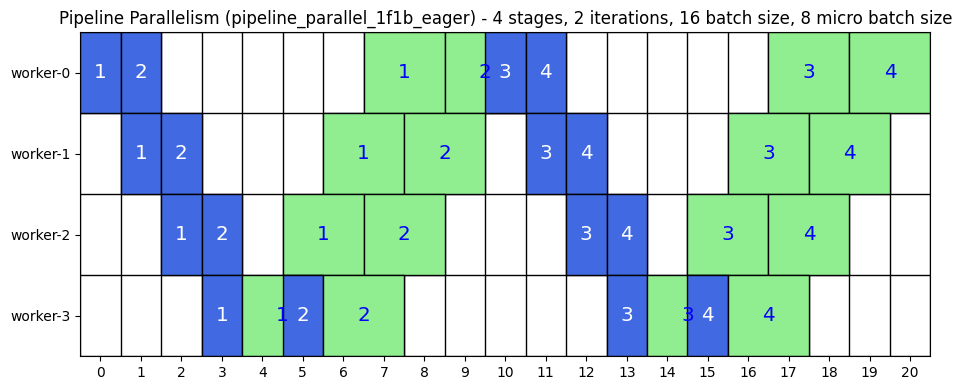

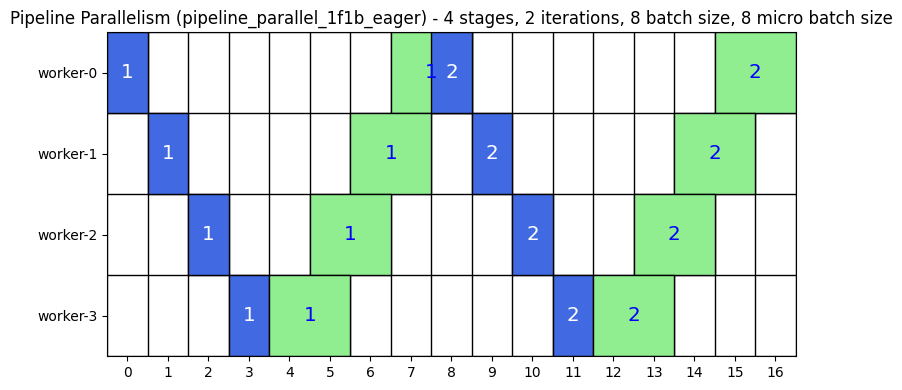

In [9]:
# Eager 1F1B: 1F1B scheduling with eager forward for better overlap between
# computation and communication

def pipeline_parallel_1f1b_eager(
    num_stages, iteration=1, batch_size=64, micro_batch_size=8
):
    return pipeline_parallel_1f1b(
        num_stages,
        iteration=iteration,
        batch_size=batch_size,
        micro_batch_size=micro_batch_size,
        eager=True,
    )


plot_pipeline_parallel(
    pipeline_parallel_1f1b_eager,
    num_stages=4,
    iteration=2,
    batch_size=64,
    micro_batch_size=8,
)

plot_pipeline_parallel(
    pipeline_parallel_1f1b_eager,
    num_stages=4,
    iteration=2,
    batch_size=32,
    micro_batch_size=8,
)

plot_pipeline_parallel(
    pipeline_parallel_1f1b_eager,
    num_stages=4,
    iteration=2,
    batch_size=16,
    micro_batch_size=8,
)

plot_pipeline_parallel(
    pipeline_parallel_1f1b_eager,
    num_stages=4,
    iteration=2,
    batch_size=8,
    micro_batch_size=8,
)

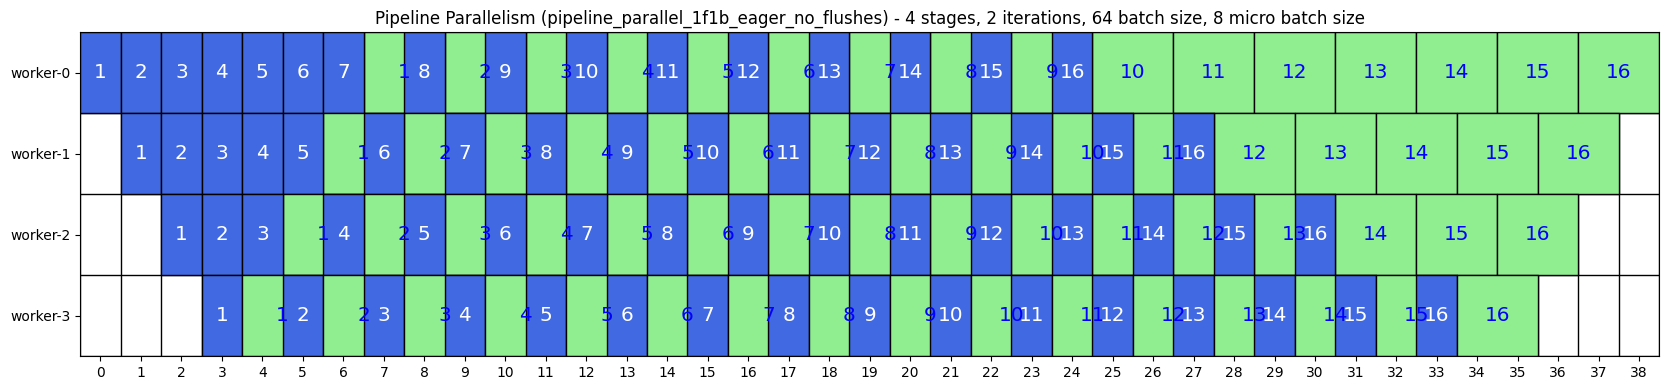

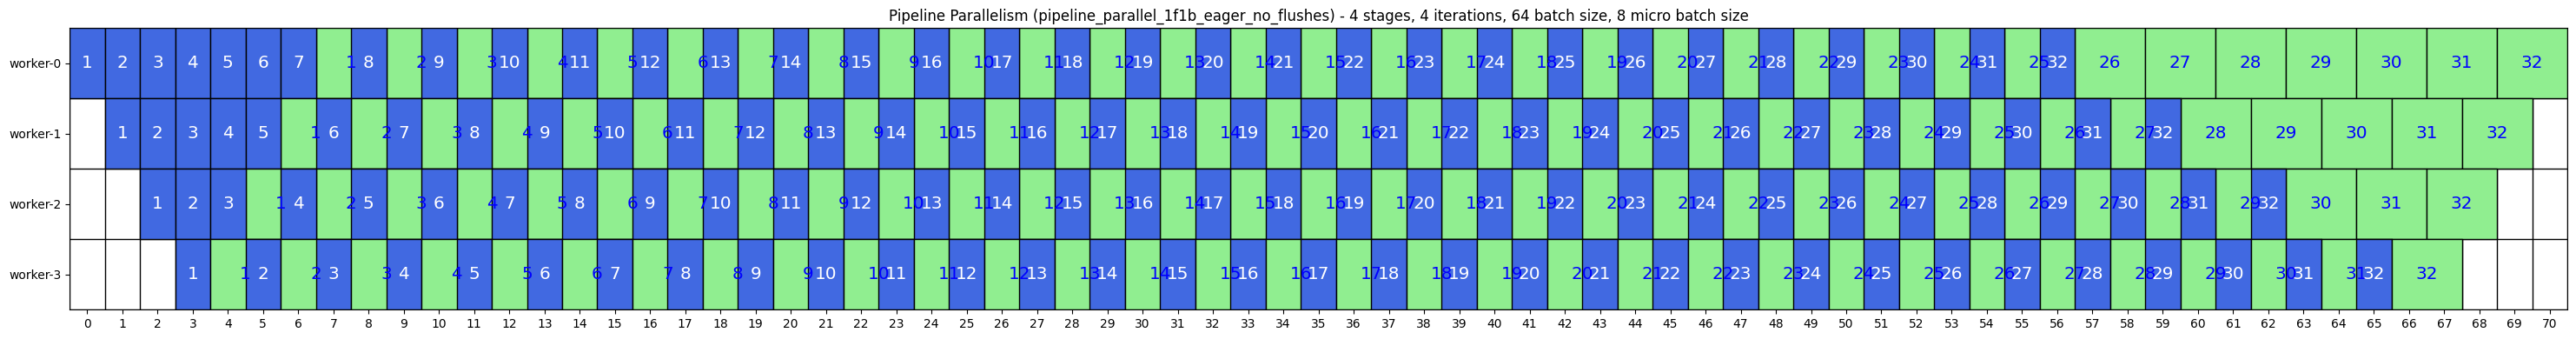

In [10]:
# Combine of Eager 1F1B and Pipedream-2BW

def pipeline_parallel_1f1b_eager_no_flushes(
    num_stages, iteration=1, batch_size=64, micro_batch_size=8
):
    # no flushes, equals to consecutive eager-1F1B
    return pipeline_parallel_1f1b(
        num_stages,
        iteration=iteration,
        batch_size=batch_size,
        micro_batch_size=micro_batch_size,
        eager=True,
        no_flush=True,
    )


plot_pipeline_parallel(
    pipeline_parallel_1f1b_eager_no_flushes,
    num_stages=4,
    iteration=2,
    batch_size=64,
    micro_batch_size=8,
)

plot_pipeline_parallel(
    pipeline_parallel_1f1b_eager_no_flushes,
    num_stages=4,
    iteration=4,
    batch_size=64,
    micro_batch_size=8,
)

### Compare with vocab

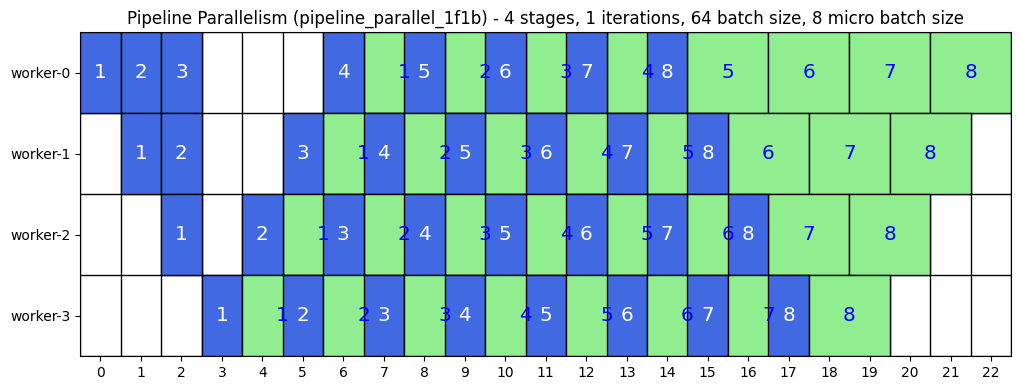

In [11]:
plot_pipeline_parallel(
    pipeline_parallel_1f1b, num_stages=4, iteration=1, batch_size=64, micro_batch_size=8
)

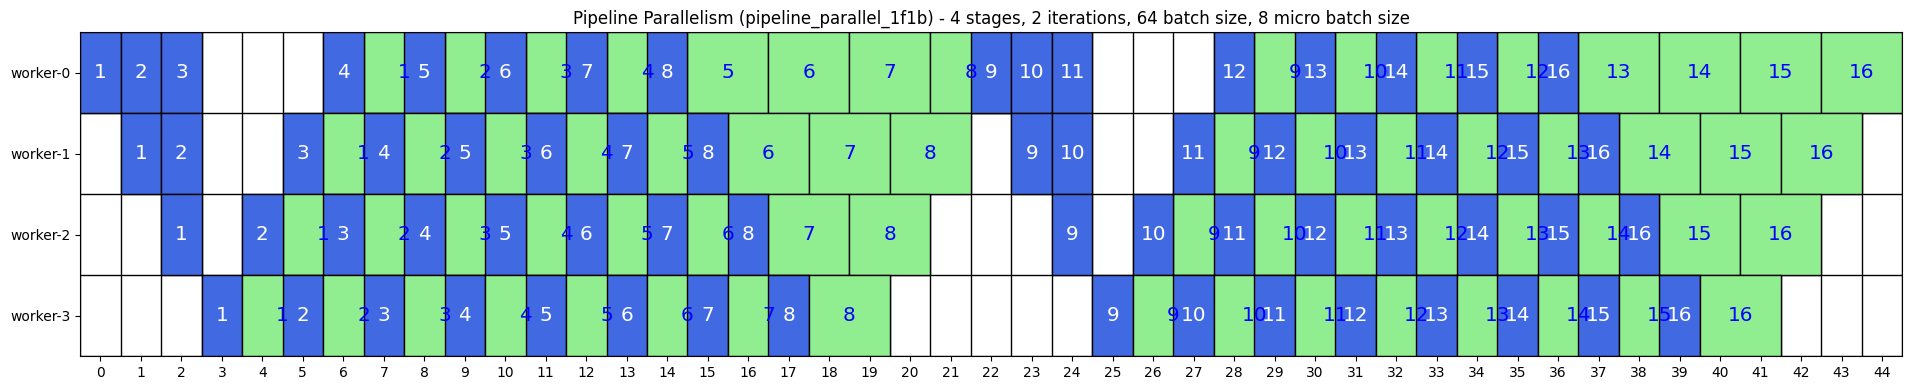

In [12]:
plot_pipeline_parallel(
    pipeline_parallel_1f1b, num_stages=4, iteration=2, batch_size=64, micro_batch_size=8
)

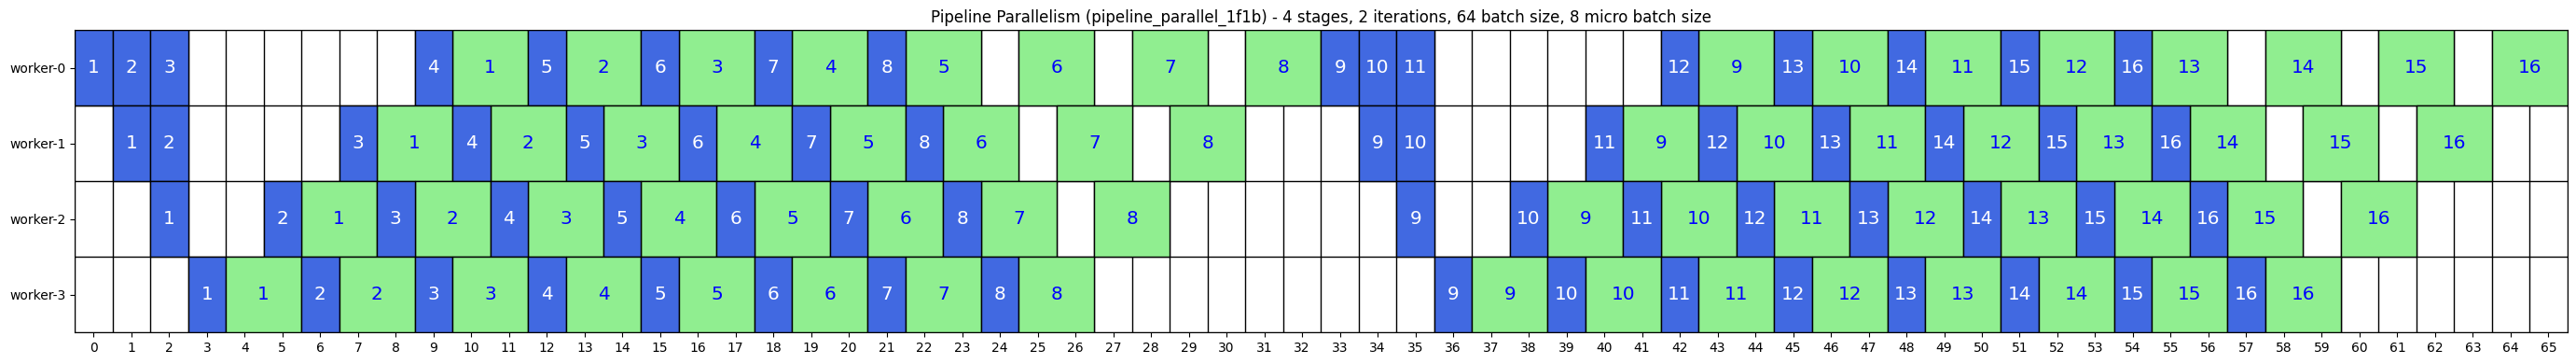

In [18]:
plot_pipeline_parallel(
    pipeline_parallel_1f1b, num_stages=4, iteration=2, batch_size=64, micro_batch_size=8
)